In [30]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())



In [12]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday)
    data["hour_average"] = map(code_mean(data[:test_index], 'hour', "y").get, data.hour)

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [13]:
def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(dataset.Users, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

In [46]:
dataset = pd.read_csv("../hm/data/eu_gdp_eu28.csv", sep=",", index_col=0)

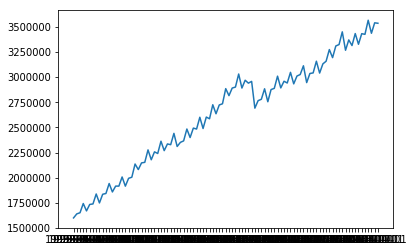

In [47]:
plt.plot(dataset)

In [ ]:
lag_start=5
lag_end=20
test_size=0.15

data = pd.DataFrame(dataset.copy())
data.columns = ["y"]

# считаем индекс в датафрейме, после которого начинается тестовыый отрезок
test_index = int(len(data)*(1-test_size))

# добавляем лаги исходного ряда в качестве признаков
for i in range(lag_start, lag_end):
    data["lag_{}".format(i)] = data.y.shift(i)

data.index = pd.to_datetime(data.index)

data["quarter"] = data.index.quarter
data["year"] = data.index.year

In [55]:
data["year"] > 2008

time
1995-01-01    False
1995-04-01    False
1995-07-01    False
1995-10-01    False
1996-01-01    False
1996-04-01    False
1996-07-01    False
1996-10-01    False
1997-01-01    False
1997-04-01    False
1997-07-01    False
1997-10-01    False
1998-01-01    False
1998-04-01    False
1998-07-01    False
1998-10-01    False
1999-01-01    False
1999-04-01    False
1999-07-01    False
1999-10-01    False
2000-01-01    False
2000-04-01    False
2000-07-01    False
2000-10-01    False
2001-01-01    False
2001-04-01    False
2001-07-01    False
2001-10-01    False
2002-01-01    False
2002-04-01    False
              ...  
2011-04-01     True
2011-07-01     True
2011-10-01     True
2012-01-01     True
2012-04-01     True
2012-07-01     True
2012-10-01     True
2013-01-01     True
2013-04-01     True
2013-07-01     True
2013-10-01     True
2014-01-01     True
2014-04-01     True
2014-07-01     True
2014-10-01     True
2015-01-01     True
2015-04-01     True
2015-07-01     True
2015-10-01     

In [ ]:
data['break'] = [data["year"] > 2008]*1

In [48]:
# считаем средние только по тренировочной части, чтобы избежать лика
data['quarterly_average'] = map(code_mean(data[:test_index], 'quarter', "y").get, data.quarter)

# выкидываем закодированные средними признаки 
data.drop(["quarter", "year"], axis=1, inplace=True)

data = data.dropna()
data = data.reset_index(drop=True)

# разбиваем весь датасет на тренировочную и тестовую выборку
X_train = data.loc[:test_index].drop(["y"], axis=1)
y_train = data.loc[:test_index]["y"]
X_test = data.loc[test_index:].drop(["y"], axis=1)
y_test = data.loc[test_index:]["y"]

ValueError: Length of values does not match length of index

In [25]:
X_train

,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,is_weekend,weekday_average,hour_average
0,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,1749618.7,1838489.7,1739728.5,1734793.8,1670650.3,1743834.9,1652305.0,1640884.3,1600923.5,0,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>
1,2007455.8,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,1749618.7,1838489.7,1739728.5,1734793.8,1670650.3,1743834.9,1652305.0,1640884.3,1,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>
2,1916238.8,2007455.8,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,1749618.7,1838489.7,1739728.5,1734793.8,1670650.3,1743834.9,1652305.0,1,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>
3,1994163.7,1916238.8,2007455.8,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,1749618.7,1838489.7,1739728.5,1734793.8,1670650.3,1743834.9,1,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>
4,2004996.5,1994163.7,1916238.8,2007455.8,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,1749618.7,1838489.7,1739728.5,1734793.8,1670650.3,1,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>
5,2136134.7,2004996.5,1994163.7,1916238.8,2007455.8,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,1749618.7,1838489.7,1739728.5,1734793.8,0,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>
6,2080875.3,2136134.7,2004996.5,1994163.7,1916238.8,2007455.8,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,1749618.7,1838489.7,1739728.5,1,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>
7,2147249.4,2080875.3,2136134.7,2004996.5,1994163.7,1916238.8,2007455.8,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,1749618.7,1838489.7,1,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>
8,2152786.2,2147249.4,2080875.3,2136134.7,2004996.5,1994163.7,1916238.8,2007455.8,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,1749618.7,0,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>
9,2276357.4,2152786.2,2147249.4,2080875.3,2136134.7,2004996.5,1994163.7,1916238.8,2007455.8,1916750.3,1916808.6,1858775.8,1942571.0,1843306.7,1835861.2,0,<map object at 0x7f38db94ba20>,<map object at 0x7f38d2616e48>


In [16]:
prepareData(dataset)

AttributeError: 'Index' object has no attribute 'to_datetime'

In [15]:
XGB_forecast(dataset, test_size=0.2, lag_start=5, lag_end=30)

AttributeError: 'DataFrame' object has no attribute 'Users'